<a href="https://colab.research.google.com/github/RobolinkInc/zumi/blob/master/sample/deep-learning-demos/tourist/Z%C3%BCmiStopsAtLandmarks-Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#How to Control a Robot with a NN

This robot has an image sensor, and 4 arrow keys for control. We will control the robot manually first, then log the image, and inputs at each moment. We will use these as examples for our NN to reproduce.

This will make a model capable of running and training on a PiZero.

## First define a NN

In [0]:
import keras

keras.backend.clear_session()

Using TensorFlow backend.


In [0]:
image_shape = (64,64,3) #color image
# image_shape = (32,32,1) #monochrome image
num_outputs = 6  # left, right, up, eiffel, chicago, start


import keras
from keras.layers import Input, Conv2D, Dense, Flatten, Lambda
from keras.layers.normalization import BatchNormalization

def make_model():
  '''
  define the layer definitions, inputs, and outputs of the NN
  '''
  img_in = Input(shape=image_shape)
  x = img_in
  x = BatchNormalization()(x)
  #These convolutional layers can be enabled once you have a lot more data.
  #x = Conv2D(24, (5,5), strides=(2,2), activation='relu')(x)
  #x = Conv2D(32, (5,5), strides=(2,2), activation='relu')(x)
  #x = Conv2D(64, (5,5), strides=(2,2), activation='relu')(x)
  #x = Conv2D(64, (3,3), strides=(1,1), activation='relu')(x)
  #x = Conv2D(64, (3,3), strides=(1,1), activation='relu')(x)
  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  x = Dense(32, activation='relu')(x)
  x = Dense(num_outputs, activation='softmax')(x)

  model = keras.models.Model(inputs=[img_in], outputs=[x])
  model.compile(optimizer="adam", metrics=['acc'], loss='categorical_crossentropy')
  return model

model = make_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 3)         12        
_________________________________________________________________
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                786496    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 788,786
Trainable params: 788,780
Non-trainable params: 6
_________________________________________________________________
None

##Clear out the previous set of data from Google Drive

`python3 /home/pi/zumi/sample/deep-learning-demos/driving/ClearImagesFromCloud.py --noauth_local_webserver`

##Record some data.

Run this script on Zumi: 

`python3 /home/pi/zumi/sample/deep-learning-demos/tourist/train_landmark.py`

Use W, A, and S to control the robot and Z when you want to stop at the landmark.

Upload the training data to [this folder](https://drive.google.com/drive/u/3/folders/1NwZ7PWLM4ZlHcvZhEWAM2N7YJDPhM9Pt) on Google Drive

##Upload data from Zumi to Google Drive

`python3 /home/pi/zumi/sample/deep-learning-demos/driving/SaveImagesToCloud.py --noauth_local_webserver`



#Load images from Google Drive

In [0]:
from google.colab import drive
drive.mount("/content/drive")

!ls "/content/drive/My Drive/Zumi-Training-Data" | wc -l

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2678


In [0]:
import cv2
import numpy 
import os
import random

files = os.listdir('/content/drive/My Drive/Zumi-Training-Data')
print("Loading " + str(len(files)) + " files...")

images = []
commands = []
val_images = []
val_commands = []
split = 0.2
up_images = 0
right_images = 0
left_images = 0
eiffel_images = 0
chicago_images = 0
start_images = 0
ignored_images = 0

for file_name in files:
  
  try:
    image_bgr = cv2.imread('/content/drive/My Drive/Zumi-Training-Data/' + file_name)
    image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  except:
    print("failed to read", file_name)
    break
  
  filename_pieces = file_name.split(".")
  command = filename_pieces[2]

  command_array = numpy.zeros(num_outputs)
  if(command == "up"): 
    up_images += 1
    arrow_index = 0
  elif(command == "left"): 
    arrow_index = 1
    left_images += 1
  elif(command == "right"): 
    arrow_index = 2
    right_images += 1
  elif(command == "eiffel"): 
    arrow_index = 3
    eiffel_images += 1
  elif(command == "chicago"): 
    arrow_index = 4
    chicago_images += 1
  elif(command == "start"): 
    arrow_index = 5
    start_images += 1
  else:
    #print("Invalid command: " + command)
    ignored_images += 1
    continue
    
  if len(images) % 100 == 0:
    print("#", end="")
    
  command_array[arrow_index] = 1.0
  
  if random.random() < split:
    val_images.append(image)
    val_commands.append(command_array)
  else:
    images.append(image)  
    commands.append(command_array)
  
print()
  
print("Training with", len(images), "images, testing with", len(val_images))
print(str(up_images) + " were UP. " + str(left_images) + " were LEFT. " + str(right_images) + " were RIGHT. " + str(eiffel_images) + " were EIFFEL. " + str(chicago_images) + " were CHICAGO. " + str(start_images) + " were START.")
print(ignored_images, "images ignored because unknown command.")

#duplicate data so we can use fewer epochs
#This is a hack and should be replaced with more data
'''
for i in range(2):
  images = images + images
  commands = commands + commands
  val_images = val_images + val_images
  val_commands = val_commands + val_commands
'''

train_images = numpy.array(images)
train_commands = numpy.array(commands)
test_images = numpy.array(val_images)
test_commands = numpy.array(val_commands)



Loading 2678 files...
############################
Training with 2152 images, testing with 523
1009 were UP. 648 were LEFT. 437 were RIGHT. 232 were EIFFEL. 274 were CHICAGO. 75 were START.
3 images ignored because unknown command.


In [0]:
train_images.shape

(2152, 64, 64, 3)

## Train the NN to reproduce the controls given the inputs

This will stop training when the accuracy against the test set - or val_acc - stops improving for 6 epochs.

Only the best weights will be saved out.


In [0]:
import keras

weights_filename = 'landmark_weights.h5'

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=6, 
                                                verbose=True, 
                                                mode='auto')

save_best = keras.callbacks.ModelCheckpoint(weights_filename, save_best_only=True, save_weights_only="True")

hist = model.fit(train_images, train_commands, epochs=20, validation_data=[test_images, test_commands], callbacks=[early_stop, save_best])


Train on 2152 samples, validate on 523 samples
Epoch 1/20
2152/2152 [==============================] - 2s 946us/step - loss: 1.6983 - acc: 0.6366 - val_loss: 1.3854 - val_acc: 0.6750
Epoch 2/20
2152/2152 [==============================] - 1s 320us/step - loss: 0.9694 - acc: 0.7430 - val_loss: 0.9683 - val_acc: 0.7208
Epoch 3/20
2152/2152 [==============================] - 1s 330us/step - loss: 0.7528 - acc: 0.7983 - val_loss: 1.1374 - val_acc: 0.7380
Epoch 4/20
2152/2152 [==============================] - 1s 327us/step - loss: 0.6805 - acc: 0.8169 - val_loss: 1.1030 - val_acc: 0.7400
Epoch 5/20
2152/2152 [==============================] - 1s 323us/step - loss: 0.9089 - acc: 0.7951 - val_loss: 1.1984 - val_acc: 0.7170
Epoch 6/20
2152/2152 [==============================] - 1s 344us/step - loss: 0.6992 - acc: 0.8443 - val_loss: 1.2771 - val_acc: 0.7438
Epoch 7/20
2152/2152 [==============================] - 1s 334us/step - loss: 0.6282 - acc: 0.8494 - val_loss: 1.1572 - val_acc: 0.7400
E

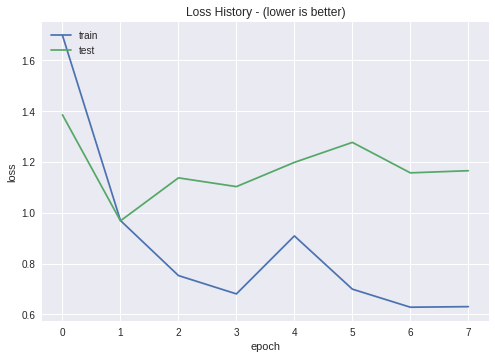

In [0]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss History - (lower is better)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## How well against specific examples in our test set?

This will take N random samples from the test set. This is significant because these are the images held asside that the 
network did NOT see during training. In other words, they tell you how well your model will generalize.

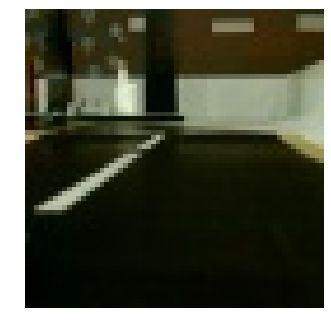

Sample 0
Conf: 92.71 %
Pred: 0
Truth: 0
Correct: True



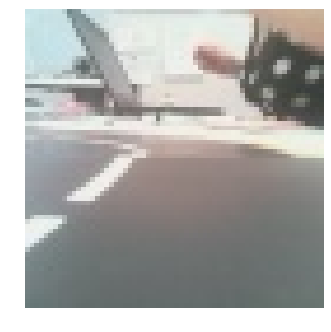

Sample 1
Conf: 99.99 %
Pred: 0
Truth: 2
Correct: False



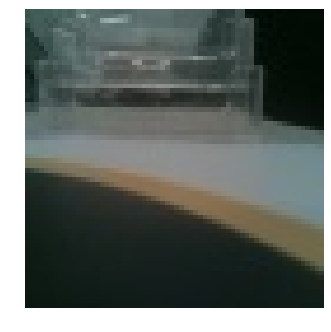

Sample 2
Conf: 68.56 %
Pred: 0
Truth: 0
Correct: True



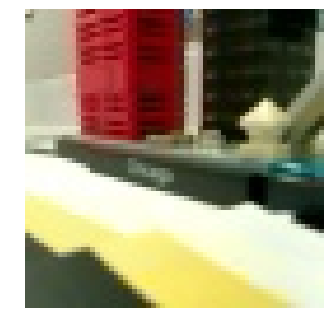

Sample 3
Conf: 99.85 %
Pred: 4
Truth: 0
Correct: False



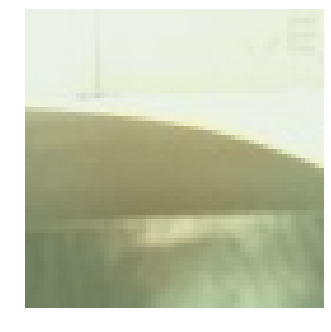

Sample 4
Conf: 100.00 %
Pred: 0
Truth: 2
Correct: False



In [0]:
import numpy as np

def eval(iSample):
  iImage = random.randint(0, len(test_images))
  img = test_images[iImage]
  plt.axis('off')
  plt.imshow(img)
  plt.show()
  y_prob = model.predict(img[None, :, :, :])
  pred = np.argmax(y_prob[0])
  truth = np.argmax(commands[iSample])
  print("Sample", iSample)
  print("Conf: %.2f" % (y_prob[0][pred] * 100.0), "%")
  print("Pred:", pred)
  print("Truth:", truth)
  print("Correct:", truth == pred)
  print()
  
for i in range(5):
  eval(i)

## Save and download the model

In [0]:
import json
from google.colab import files

json_string = model.to_json()
with open('landmark_model.json', 'w') as outfile:  
    json.dump(json_string, outfile)

files.download('landmark_model.json')

#this getting saved from training session now.
# model.save_weights(weights_filename)

files.download(weights_filename)

## Send to Pi0

scp -r /home/joonspoon/Downloads/landmark_weights.h5 pi@june-zumi.local:/home/pi/zumi/sample/deep-learning-demos/tourist/

scp -r /home/joonspoon/Downloads/landmark_model.json pi@june-zumi.local:/home/pi/zumi/sample/deep-learning-demos/tourist/

## Use to control robot

By running [this notebook](https://github.com/RobolinkInc/zumi/tree/master/sample/deep-learning-demos/driving/ControlUsingModel.ipynb)  on the robot.

http://june-zumi.local:5555/notebooks/sample/deep-learning-demos/driving/ControlUsingModel.ipynb

